## Deep learning (LSTM) for movie reviews

Deep learning (**bidirectional LSTM**) application for sentiment analysis of movie reviews. Application of NLP methods to prepare words for a model.

1. Importing and Exploring data
2. Preparing data (tokenizing)
3. Building a model (Word Embeddings)
4. Fitting and Evaluating a model

#### IMDB dataset having 50K movie reviews (dataset): 
- Reviews
- Sentiment:
- - Negative (1-5 rate)
- - Positive (7-10 rate)

To start from beginning, RNN was developed to handle NLP tasks well, since it can solve sequential problems efficiently. Due to gradient vanishing and explosion problem, LSTM was developed which will be used for movie reviews.

Goal is to predict the number of positive and negative reviews based on sentiments analysis by using LSTM. 

Additionally **bidirectional LSTM** is used since various papers gave evaluation that it performed better than traditional LSTM


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import numpy as np
import seaborn as sns
import statistics 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


### 1. Importing  and exploring data

In [2]:
reviews = pd.read_csv("IMDB Dataset.csv")

print(reviews.isnull().values.any())
print(reviews.shape)
reviews.head()

False
(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Stopwords are not necessery for nlp task

In [3]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
             "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", 
             "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", 
             "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", 
             "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", 
             "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", 
             "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", 
             "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", 
             "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", 
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", 
             "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", 
             "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
             's','e','ll','t','Mr', 's' ]

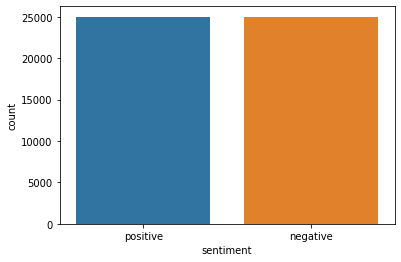

In [4]:
sns.countplot(x='sentiment', data=reviews)

Classification targets have similar values which makes distribution of samples are similar

### 2. Preparing data
- Cleaning html hashtags
- Cleaning special characters
- clearing multiple spaces
- Removing stopwords
- making all letters lower cap

In [5]:
def remove_tags(text):
    html_tags = re.compile(r'<.*?>')
    return html_tags.sub(r'', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

'''Remove:
html tags
Single character
non alphabetic calue
multiple spaces
stopwords
all words have are lower (not capital characters)
'''

def preprocess_text(sen):

    sentence = remove_tags(sen)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = remove_stopwords(sentence)
    sentence = sentence.lower()
    
    return sentence

Splitting into X and Y parts

In [6]:
X = []
sentences = list(reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Since we focusing to have numeric values, positive -> 1, while negative -> 0

In [7]:
Y = reviews['sentiment']
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [8]:
np.unique(Y,return_counts=True)

(array([0, 1]), array([25000, 25000]))

In order to test model, it will be splitted into two parts

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [10]:
X_train[0]

'got christopher lee got huge banks computers make teletype noises letters appear screen got radioactive isotopes not glow dark emit pulsing thrumming noises got volcanoes evil aliens disguised nuns tidal waves earthquakes exploding cars exploding coffee machines climax entire planet blows earth film managed incredibly mind numbingly dull answer friend movie made establishing shots involving long tracks pans zooms combinations occasionally three nothing except give crew something endless shots protagonists driving getting cars driving walking around looking stuff getting cars driving just sat watching endless parade nothingness stupefaction muttering say something please somebody just say something something anything dialogue come terrible maybe minutes measured different scale typically meaningless line script culminates destruction world stock footage justified speech lee head alien planet earth emitted abundance diseases contaminating universe planets light years away will suffer un

Data looks reasonable to test

#### Tokenizing data

It will be tokenized into 10000 different values. Values which are out of limit, will be replaced by OOV

In [11]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [12]:
len(word_index) # Length of the words

87392

In [13]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Different sentences will have different length, so it is important to standardize input length

123.3314


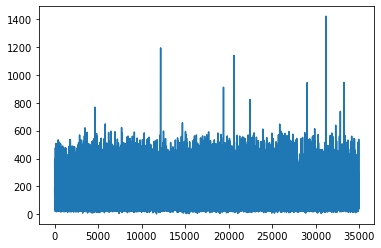

In [14]:
# Lengths of sentences #
lengths = [len(i) for i in X_train]
print(statistics.mean(lengths))
plt.plot(lengths)

Since the average is around 120, it will be selected to have maximum 120.
- List with less values will be added 0 to complete a list of 120
- List with higher value will be reduced to 120


In [15]:
# First 10 values of tokenized words #
list(tokenizer.word_index.keys())[0:10]

['<OOV>', 'movie', 'film', 'not', 'one', 'like', 'just', 'good', 'can', 'no']

In [16]:
maxlen = 120

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_train[0]

array([274,   1,   1,   1,  94, 159, 395, 274,   1,   1,   7,   1,  64,
         1,   1,   1,   1,   1,  54,  58, 462,   1,   7,  54,  58,  58,
       138, 306, 121, 273, 170, 134,   1, 175,   1,   1,   1, 242, 132,
         1,   1,  86,   1, 762,   1,   1, 764, 294,   1,   1, 570,   1,
         1,   1,   1,   1,   1, 530,  71, 144,  21,   1, 756,   1,   1,
         1, 132, 372, 326,   1,  81, 326, 787, 632,   1,  29,   1, 195,
         1,   1,  91, 378, 270, 242, 474, 942,   1,   2, 137,   1,   1,
         1,   1,   1,   2, 492, 195, 222,   1, 387,   1, 764, 118,   1,
         1,   1, 180, 152,   1,   1,   1, 304,  80, 390,   1, 274,   1,
         1,  25,   1], dtype=int32)

Data seems tokenized well and ready to be used

Additionally, there are 87426 unique words, but we do not need all of them, since we our dataset is tokenized into 10000 different values

### Word Embeddings

This is a technique where words are encoded as real-valued vectors in a high-dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

While doing with keras, deep learning, embedding is provided, so it can be done while constructing a model instantly

### 3. Building a model

In [17]:
model = Sequential()
''' Embedding(size of tokenized vocabulary, number of embedding dimension, input length)'''
model.add(Embedding(vocab_size, 16, input_length=maxlen))

In [18]:
# Dropout, to reduce overfitting
model.add(Bidirectional(LSTM(32, dropout=0.2)))

In [19]:
model.add(Dense(24, activation='relu'))

In [20]:
model.add(Dense(1, activation='sigmoid'))

In [21]:
''' '''
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________
None


### 4. Fitting and Evaluating a model

- batch_size is not used, since we have a lot of samples (used batch_size as 128, did not improve the model and run 20x sower)
- Model can overfit easily, so 10 epochs are used

In [22]:
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.25)

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26250 samples, validate on 8750 samples
Epoch 1/10
26250/26250 [==============================] - 85s 3ms/step - loss: 0.4468 - accuracy: 0.7803 - val_loss: 0.3584 - val_accuracy: 0.8491
Epoch 2/10
26250/26250 [==============================] - 85s 3ms/step - loss: 0.3517 - accuracy: 0.8507 - val_loss: 0.3457 - val_accuracy: 0.8518
Epoch 3/10
26250/26250 [==============================] - 84s 3ms/step - loss: 0.3341 - accuracy: 0.8588 - val_loss: 0.3580 - val_accuracy: 0.8410
Epoch 4/10
26250/26250 [==============================] - 84s 3ms/step - loss: 0.3279 - accuracy: 0.8594 - val_loss: 0.3488 - val_accuracy: 0.8459
Epoch 5/10
26250/26250 [==============================] - 85s 3ms/step - loss: 0.3241 - accuracy: 0.8607 - val_loss: 0.3423 - val_accuracy: 0.8498
Epoch 6/10
26250/26250 [==============================] - 85s 3ms/step - loss: 0.3176 - accuracy: 0.8641 - val_loss: 0.3550 - val_accuracy: 0.8485
Epoch 7/10
26250/26250 [==============================] - 87s 3ms/ste

In [23]:
score = model.evaluate(X_test, Y_test)

15000/15000 [==============================] - 11s 730us/step


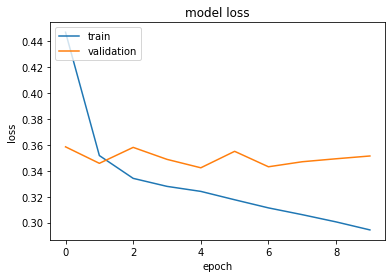

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

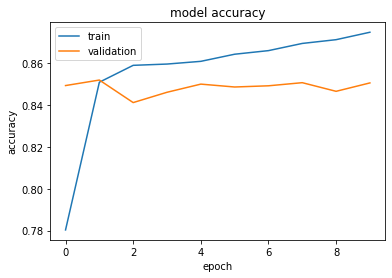

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

Clearly a model does not improve from the first epoch, but not overfitting, since validation standard deviation having the same level

In [26]:
score

[0.34866400529543556, 0.8521999716758728]

evaluation gives the same mean values validation had (~0.3487 loss, 0.8522 accuracy)

In [27]:
Y_predict = model.predict(X_test)

In [28]:
Y_predict[Y_predict >= 0.5] = 1
Y_predict[Y_predict < 0.5] = 0
Y_predict = Y_predict.T[0]

In [29]:
pd.crosstab(Y_test, Y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,6216,1274,7490
1,943,6567,7510
All,7159,7841,15000


Given confusion matrix explains more if a model is overfitted for some target (which is not).   

But the main part for this task is to avoid overfitting. By changing parameters, the model was easily overfitting. For instance, increasing tokenizing words into 5000 and 10000, increased train accuracy up to 97%, but overfitting from the first epoch in deep learning model where in the end, a model on test data achieved 85% of accuracy

Obviously in order to tell if a model is really good as it is, it should be compared with other classification models. The main purpose of this was to show how deep learning is applied. The model can be improved as well by:
- Improving NLP task: Increasing a size of vocabulary in tokenizing part, Change words limit in sentence (It can increase overfitting)
- Change parameters in deep learning models (increasing embedding dimension, change batch_size). Important to mentiont that this task could require a high computation power
- Adding more hidden layers 